# 时间序列预测任务

- 数据集：气温数据，多种指标
- 任务目标：预测未来某一时间点的气温/未来某一时间片段的气温


In [1]:
import warnings
warnings.filterwarnings("ignore")
from __future__ import absolute_import, division, print_function, unicode_literals
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
plt.style.use('classic')
mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## 数据地址

https://www.kaggle.com/stytch16/jena-climate-2009-2016

## 读取数据，查看数据

In [4]:
df = pd.read_csv('jena_climate_2009_2016.csv')
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 420551 entries, 0 to 420550
Data columns (total 15 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   Date Time        420551 non-null  object 
 1   p (mbar)         420551 non-null  float64
 2   T (degC)         420551 non-null  float64
 3   Tpot (K)         420551 non-null  float64
 4   Tdew (degC)      420551 non-null  float64
 5   rh (%)           420551 non-null  float64
 6   VPmax (mbar)     420551 non-null  float64
 7   VPact (mbar)     420551 non-null  float64
 8   VPdef (mbar)     420551 non-null  float64
 9   sh (g/kg)        420551 non-null  float64
 10  H2OC (mmol/mol)  420551 non-null  float64
 11  rho (g/m**3)     420551 non-null  float64
 12  wv (m/s)         420551 non-null  float64
 13  max. wv (m/s)    420551 non-null  float64
 14  wd (deg)         420551 non-null  float64
dtypes: float64(14), object(1)
memory usage: 48.1+ MB
None


,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


每10分钟会记录一次，有多个指标

## 任务说明
- 举例：用前10天的数据，来预测第11天的结果
- 前10天的数据，就是一个时间序列

## 构建序列数据

- dataset表示输入的数据集，里面可以是一个或者多个列特征
- history_size表示时间窗口的大小：
- indices = range(i-history_size, i)表示窗口序列索引，i表示每个窗口的起始位置，即（0,0+history_size）（1，1+history_size）。。。
- target_size表示要预测的结果是窗口后的第几个时间点，0则表示下一时间点的预测结果，取其当做标签

In [3]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i)
        # Reshape data from (history_size,) to (history_size, 1)
        data.append(np.reshape(dataset[indices], (history_size, 1)))
        labels.append(dataset[i+target_size])
    return np.array(data), np.array(labels)

前30W个样本数据当做训练的，剩余的当做验证集

In [4]:
TRAIN_SPLIT = 300000

In [5]:
tf.random.set_seed(13)

## 单特征训练模型

In [6]:
#只选一个温度特征
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

展示当前特征

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000213CFE3C2E0>],
      dtype=object)

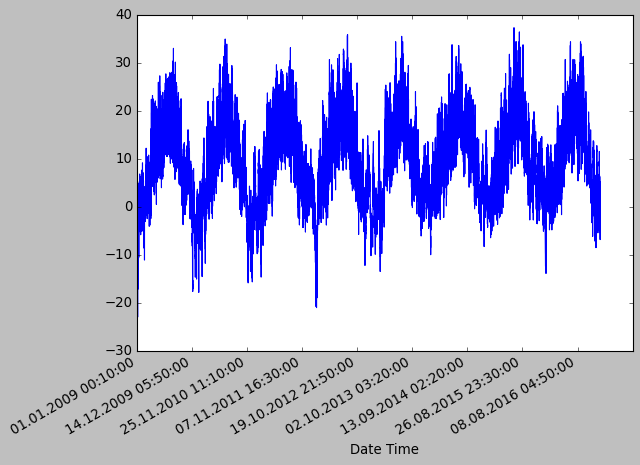

In [7]:
uni_data.plot(subplots=True)

In [8]:
uni_data = uni_data.values

### 数据预处理：标准化操作

In [55]:
# 基于训练集
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()

In [10]:
uni_data = (uni_data-uni_train_mean)/uni_train_std

窗口大小为20条数据，预测下一个时刻的气温

In [11]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

#### 数据与标签维度

In [12]:
x_train_uni.shape

(299980, 20, 1)

In [13]:
y_train_uni.shape

(299980,)

#### 打印：训练特征X与标签Y

In [14]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target temperature to predict')
print (y_train_uni[0])

Single window of past history
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Target temperature to predict
-2.1041848598100876


### 时间序列样本展示

In [15]:
def create_time_steps(length):
    time_steps = []
    for i in range(-length, 0, 1):
        time_steps.append(i)
    return time_steps

In [16]:
def show_plot(plot_data, delta, title):
    labels = ['History', 'True Future', 'Model Prediction']
    marker = ['.-', 'rx', 'go']
    time_steps = create_time_steps(plot_data[0].shape[0])
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, x in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10,label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future+5)*2])
    plt.xlabel('Time-Step')
    return plt

<module 'matplotlib.pyplot' from 'C:\\Users\\jarod\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

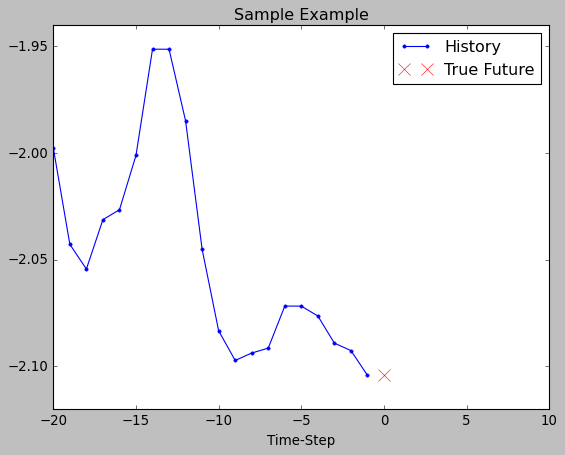

In [17]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

### 看一下平均值

In [18]:
def baseline(history):
    return np.mean(history)

<module 'matplotlib.pyplot' from 'C:\\Users\\jarod\\anaconda3\\lib\\site-packages\\matplotlib\\pyplot.py'>

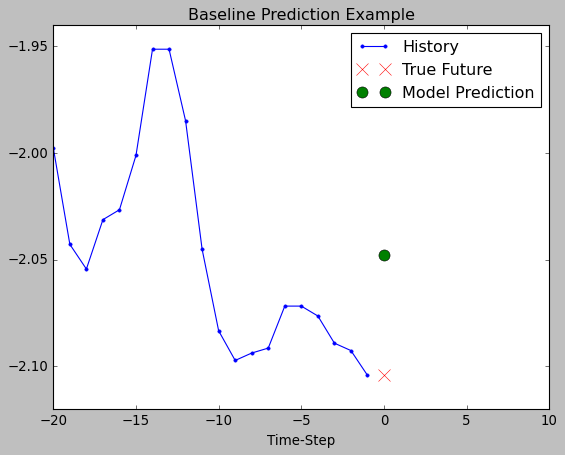

In [19]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,'Baseline Prediction Example')

### 构建RNN模型进行预测

In [20]:
BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [21]:
train_univariate

<RepeatDataset shapes: ((None, 20, 1), (None,)), types: (tf.float64, tf.float64)>

In [22]:
x_train_uni.shape[-2:]

(20, 1)

#### LSTM模型
- 长短期记忆网络（Long Short-Term Memory）

In [23]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

#### 得到一个batch的shape

In [24]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


#### 为了训练的能快点，一个epoch就训练200次

In [25]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/10
200/200 [==============================] - 1s 7ms/step - loss: 0.4075 - val_loss: 0.1351
Epoch 2/10
200/200 [==============================] - 1s 7ms/step - loss: 0.1118 - val_loss: 0.0359
Epoch 3/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0489 - val_loss: 0.0290
Epoch 4/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0443 - val_loss: 0.0258
Epoch 5/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0299 - val_loss: 0.0235
Epoch 6/10
200/200 [==============================] - 2s 8ms/step - loss: 0.0317 - val_loss: 0.0224
Epoch 7/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0286 - val_loss: 0.0206
Epoch 8/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0263 - val_loss: 0.0200
Epoch 9/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0254 - val_loss: 0.0182
Epoch 10/10
200/200 [==============================] - 1s 7ms/step - loss: 0.0228 - val_loss: 0.0173

### 用训练好的模型预测结果

#### 展示其中部分数据的预测结果

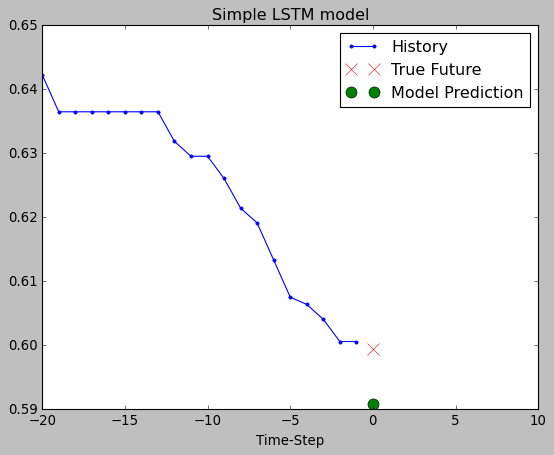

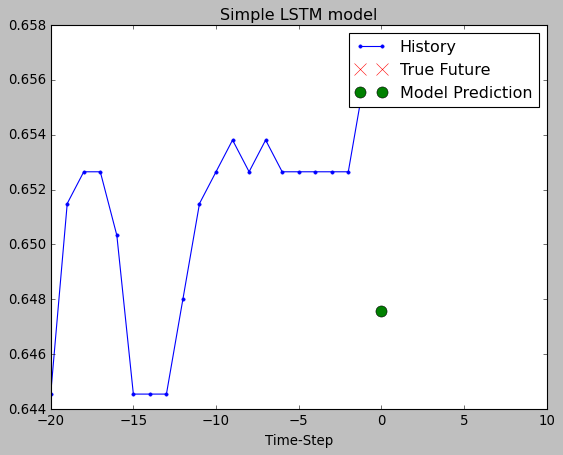

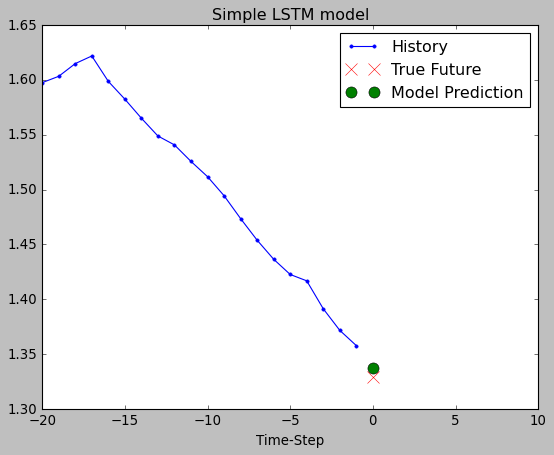

In [26]:
# 取出3个样本，做展示
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
    plot.show()

#### 有的还凑合，有的差的比较多

## 多用些特征看看效果

In [27]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [28]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


Let's have a look at how each of these features vary across time.

array([<matplotlib.axes._subplots.AxesSubplot object at 0x00000213DE034910>,
      dtype=object)

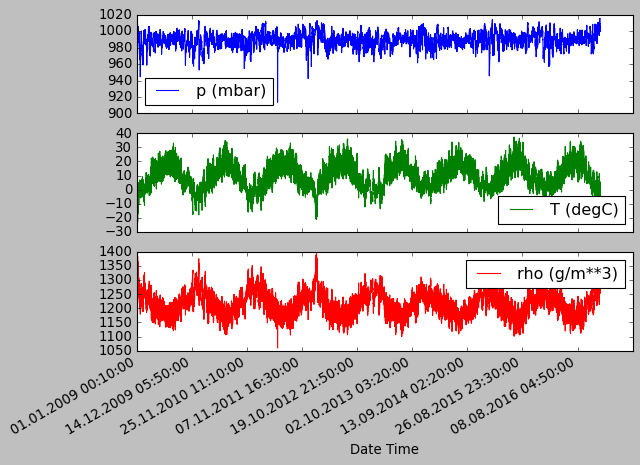

In [29]:
features.plot(subplots=True)

### 标准化的时候只能用训练数据

In [30]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)

In [31]:
dataset = (dataset-data_mean)/data_std

### 时间窗口数据制作
- 只预测接下来一个时间点的结果

In [32]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
    data = []
    labels = []

    start_index = start_index + history_size
    if end_index is None:
        end_index = len(dataset) - target_size

    for i in range(start_index, end_index):
        indices = range(i-history_size, i, step) #索引为range(0, 720, 6)，range(1, 721, 6) range(2, 722, 6)
        data.append(dataset[indices])

        if single_step:
            labels.append(target[i+target_size]) #（720+72）（721+72）
        else:
            labels.append(target[i:i+target_size])

    return np.array(data), np.array(labels)

- 选择训练窗口为5天的数据，5  * 24 * 6=720条记录
- step=6表示每6隔6个时间点实际取一次数据，即窗口大小：720/6=120 ，索引为range(0, 720, 6)，range(0, 720, 6)
- 要预测的结果（标签）为12小时后的温度值，即12*6=72,72个时间点后的结果

In [33]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

#### 数据维度

In [34]:
x_train_single.shape

(299280, 120, 3)

In [35]:
y_train_single.shape

(299280,)

### 构建训练数据

In [36]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [37]:
train_data_single

<RepeatDataset shapes: ((None, 120, 3), (None,)), types: (tf.float64, tf.float64)>

In [38]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

In [39]:
for x, y in val_data_single.take(1):
    print(single_step_model.predict(x).shape)

(256, 1)


In [40]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/10
200/200 [==============================] - 21s 104ms/step - loss: 0.3090 - val_loss: 0.2647
Epoch 2/10
200/200 [==============================] - 23s 114ms/step - loss: 0.2622 - val_loss: 0.2425
Epoch 3/10
200/200 [==============================] - 28s 140ms/step - loss: 0.2613 - val_loss: 0.2455
Epoch 4/10
200/200 [==============================] - 30s 148ms/step - loss: 0.2567 - val_loss: 0.2448
Epoch 5/10
200/200 [==============================] - 32s 159ms/step - loss: 0.2262 - val_loss: 0.2354
Epoch 6/10
200/200 [==============================] - 32s 158ms/step - loss: 0.2416 - val_loss: 0.2662
Epoch 7/10
200/200 [==============================] - 30s 152ms/step - loss: 0.2406 - val_loss: 0.2544
Epoch 8/10
200/200 [==============================] - 29s 145ms/step - loss: 0.2405 - val_loss: 0.2362
Epoch 9/10
200/200 [==============================] - 27s 133ms/step - loss: 0.2448 - val_loss: 0.2462
Epoch 10/10
200/200 [==============================] - 29s 147ms/step - l

### 训练结果展示

In [41]:
def plot_train_history(history, title):
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(len(loss))

    plt.figure()

    plt.plot(epochs, loss, 'b', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title(title)
    plt.legend()

    plt.show()

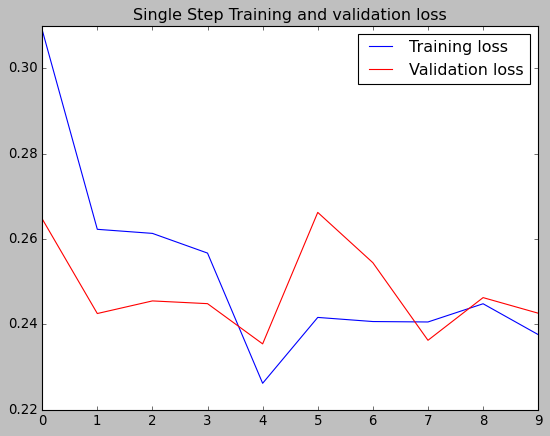

In [42]:
plot_train_history(single_step_history,
                   'Single Step Training and validation loss')

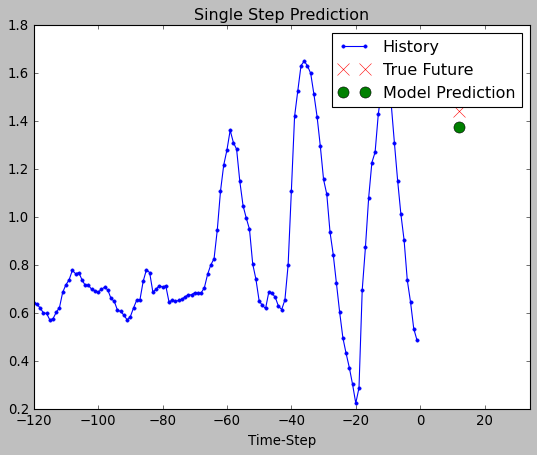

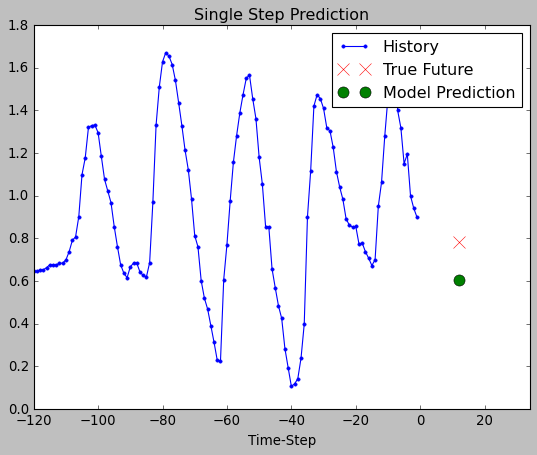

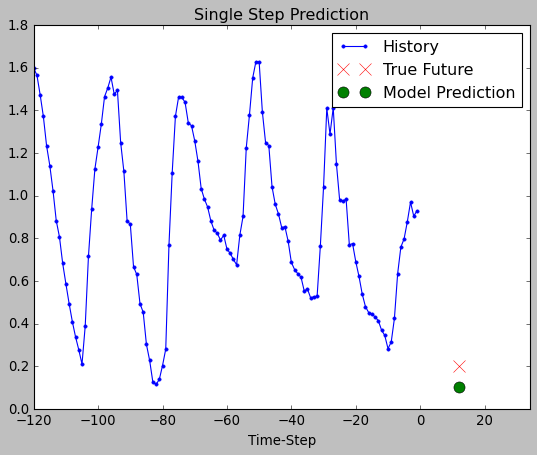

In [43]:
for x, y in val_data_single.take(3):
    plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Single Step Prediction')
    plot.show()

### 预测接下来一个时间片段的结果

In [44]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

In [45]:
x_train_multi.shape

(299280, 120, 3)

In [46]:
y_train_multi.shape

(299280, 72)

In [47]:
train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

要预测的序列

In [48]:
def multi_step_plot(history, true_future, prediction):
    plt.figure(figsize=(12, 6))
    num_in = create_time_steps(len(history))
    num_out = len(true_future)

    plt.plot(num_in, np.array(history[:, 1]), label='History')
    plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',label='True Future')
    if prediction.any():
        plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',label='Predicted Future')
    plt.legend(loc='upper left')
    plt.show()

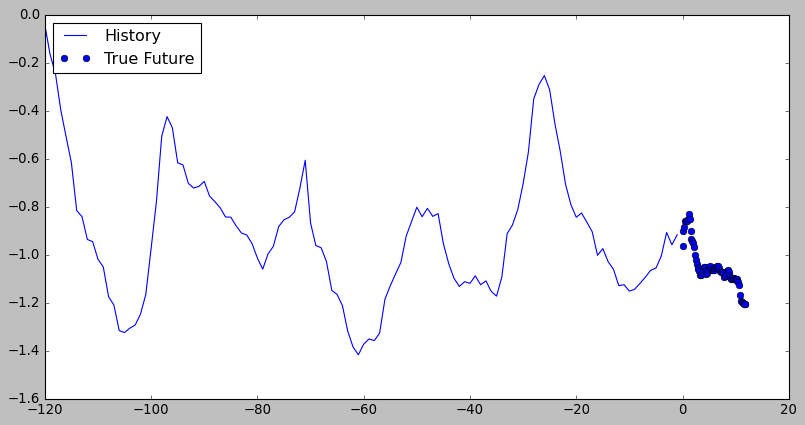

In [49]:
for x, y in train_data_multi.take(1):
    multi_step_plot(x[0], y[0], np.array([0]))

#### 2层的LSTM网络，预测72个时间结果

In [50]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

每个序列输入后都会得到72个预测结果

In [51]:
for x, y in val_data_multi.take(1):
    print (multi_step_model.predict(x).shape)

(256, 72)


In [52]:
multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/10
200/200 [==============================] - 50s 248ms/step - loss: 0.4953 - val_loss: 0.3042
Epoch 2/10
200/200 [==============================] - 53s 264ms/step - loss: 0.3467 - val_loss: 0.2863
Epoch 3/10
200/200 [==============================] - 61s 306ms/step - loss: 0.3253 - val_loss: 0.2474
Epoch 4/10
200/200 [==============================] - 64s 318ms/step - loss: 0.2399 - val_loss: 0.2025
Epoch 5/10
200/200 [==============================] - 65s 325ms/step - loss: 0.1950 - val_loss: 0.2017
Epoch 6/10
200/200 [==============================] - 70s 352ms/step - loss: 0.2047 - val_loss: 0.2043
Epoch 7/10
200/200 [==============================] - 65s 326ms/step - loss: 0.1972 - val_loss: 0.2018
Epoch 8/10
200/200 [==============================] - 73s 366ms/step - loss: 0.1950 - val_loss: 0.1963
Epoch 9/10
200/200 [==============================] - 75s 376ms/step - loss: 0.1971 - val_loss: 0.1837
Epoch 10/10
200/200 [==============================] - 72s 360ms/step - l

### 预测结果展示

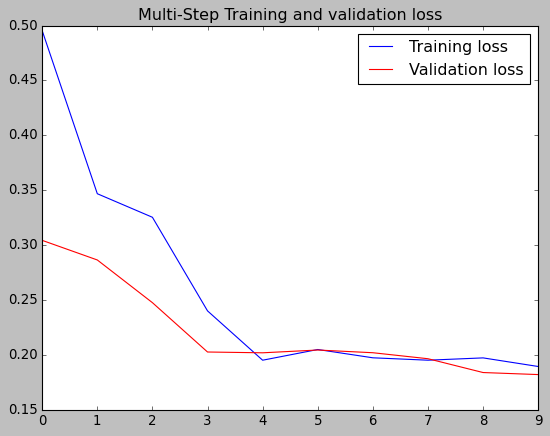

In [53]:
plot_train_history(multi_step_history, 'Multi-Step Training and validation loss')

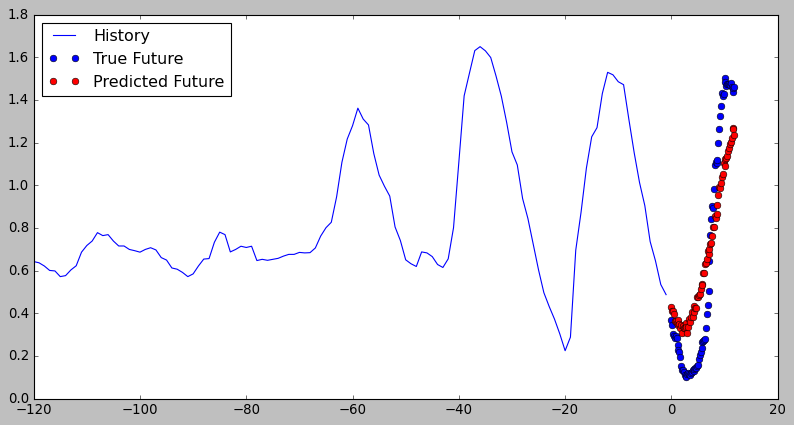

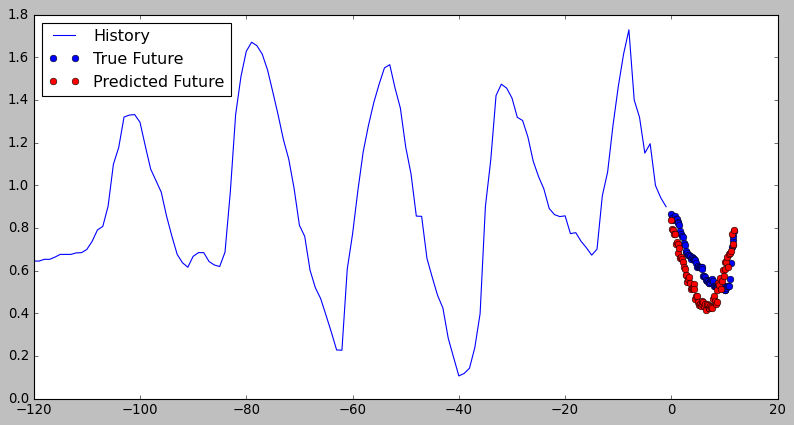

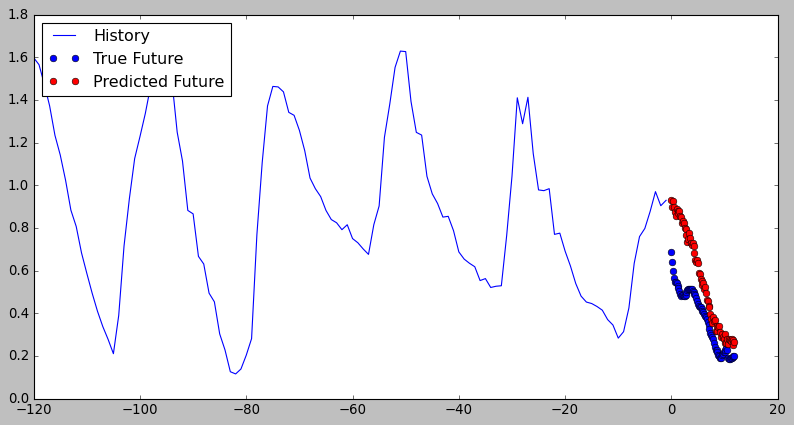

In [54]:
for x, y in val_data_multi.take(3):
    multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])